In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [2]:
df = pd.read_csv('raw_data/KaggleV2-May-2016.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
df.head(20)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [ ]:
#convert dates to datetime format

from datetime import datetime

df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)

In [ ]:
#convert gender to numerical values
df['Gender'] = df['Gender'].replace('F', 0)
df['Gender'] = df['Gender'].replace('M', 1)

In [ ]:
#check if the conversion went right
df['Gender'].unique()

In [ ]:
df['No-show'] = df['No-show'].replace('Yes', 1)
df['No-show'] = df['No-show'].replace('No', 0)

In [12]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0


In [17]:
X = df[['Gender', 'Age', 'Scholarship', 
        'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']]

y = df['No-show']

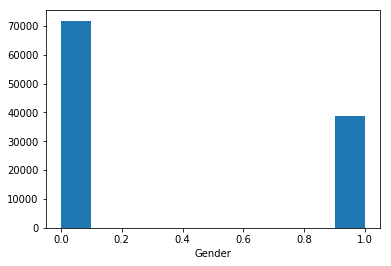

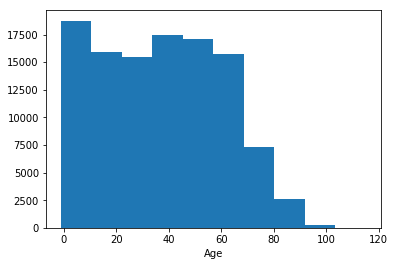

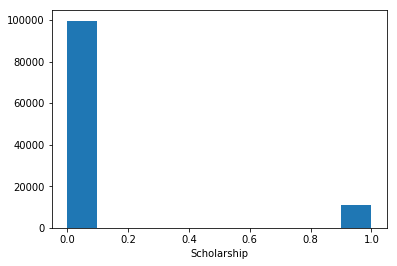

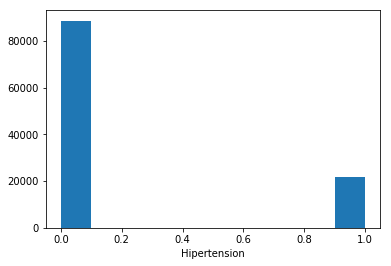

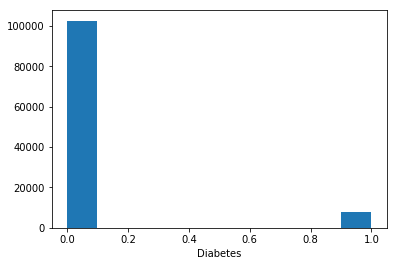

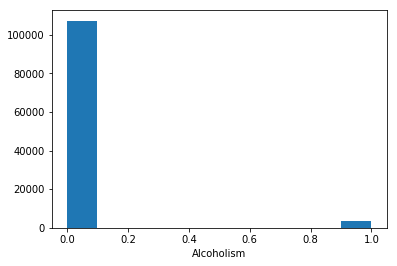

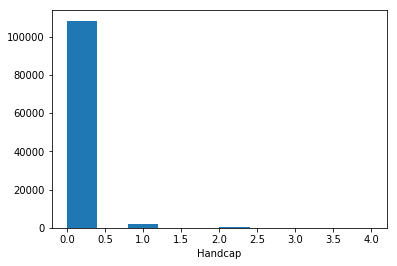

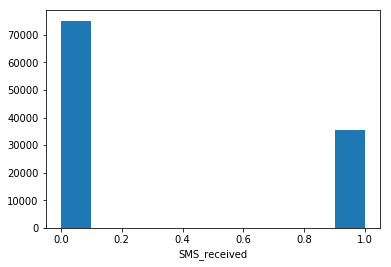

In [21]:
for column in X.columns:
    plt.hist(df[column])
    plt.xlabel(column)
    plt.show()

In [ ]:
#create column containing how many number of days in advance the applointment was scheduled
#df['days_in_advance'] =  df.AppointmentDay - df.ScheduledDay
#df['days_in_advance'] = df['days_in_advance'].apply(lambda x: x.days)

In [ ]:
#df['days_in_advance'].hist();

In [ ]:
# where days in advance is equal to -1, the date of the appoinment and date when it was scheduled is the same,
# so we can just replace it with 0

#df['days_in_advance'] = df['days_in_advance'].replace(-1, 0)

In [ ]:
#create column with month of the appointment

#df['appointment_month'] =  df.AppointmentDay.apply(lambda x: x.month)

In [ ]:
#create column with day of the week of the appointment

#df['appointment_day_of_the_week'] =  df.AppointmentDay.apply(lambda x: x.weekday())

In [ ]:
#there are multiple appointments for a lot of patients
#df.PatientId.value_counts().head()